In [157]:
!pip install tensorflow

In [158]:
!pip install --upgrade pyfluidsynth

In [159]:
!pip install --upgrade fluidsynth

In [160]:
!pip install pretty_midi
!pip install seaborn
!pip install typing

In [161]:
import tensorflow as tf
import collections
import datetime
import fluidsynth
import functools
import glob
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import numpy as np
import os
import time
import regex as re
import subprocess
import urllib
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [162]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [163]:
assert len(tf.config.list_physical_devices('GPU'))>0

AssertionError: 

In [164]:
seed=1011
tf.random.set_seed(seed)
np.random.seed(seed)

#sampling rate for audio playback
_SAMPLING_RATE=16000

In [547]:
data_dir=pathlib.Path('midi_pop_music')

In [1001]:
filenames=glob.glob(str(data_dir/'*.mid*'))
print('Number of files:',len(filenames))

Number of files: 21


In [1003]:
sample_file=filenames[0]
print(sample_file)

midi_pop_music\Apologize (1).mid


In [1004]:
pm=pretty_midi.PrettyMIDI(sample_file)

In [1005]:
print('number of instruments:',len(pm.instruments))
print('instrument name:',pretty_midi.program_to_instrument_name(pm.instruments[0].program))
print(pm.instruments)

number of instruments: 2
instrument name: Acoustic Grand Piano
[Instrument(program=0, is_drum=False, name="PianoL"), Instrument(program=0, is_drum=False, name="PianoL")]


In [1006]:
instrument1=pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument1.program)
print(instrument1.notes)

[Note(start=0.000000, end=0.250000, pitch=60, velocity=85), Note(start=0.250000, end=0.500000, pitch=55, velocity=85), Note(start=0.500000, end=0.750000, pitch=60, velocity=85), Note(start=0.750000, end=1.000000, pitch=55, velocity=85), Note(start=0.000000, end=1.000000, pitch=63, velocity=85), Note(start=1.000000, end=1.250000, pitch=60, velocity=85), Note(start=1.250000, end=1.500000, pitch=55, velocity=85), Note(start=1.500000, end=1.750000, pitch=60, velocity=85), Note(start=1.750000, end=2.000000, pitch=55, velocity=85), Note(start=1.000000, end=2.000000, pitch=63, velocity=85), Note(start=2.000000, end=2.250000, pitch=60, velocity=85), Note(start=2.250000, end=2.500000, pitch=55, velocity=85), Note(start=2.500000, end=2.750000, pitch=60, velocity=85), Note(start=2.750000, end=3.000000, pitch=55, velocity=85), Note(start=2.000000, end=3.000000, pitch=65, velocity=85), Note(start=3.000000, end=3.250000, pitch=60, velocity=85), Note(start=3.250000, end=3.500000, pitch=55, velocity=8

In [1007]:
instrument0=pm.instruments[0]
for i, note in enumerate(instrument0.notes[:]):
    print(f'{i}:pitch={note.pitch}, note_name={pretty_midi.note_number_to_name(note.pitch)},'
          f' duration={note.end-note.start:.4f}')

0:pitch=60, note_name=C4, duration=0.2500
1:pitch=55, note_name=G3, duration=0.2500
2:pitch=60, note_name=C4, duration=0.2500
3:pitch=55, note_name=G3, duration=0.2500
4:pitch=63, note_name=D#4, duration=1.0000
5:pitch=60, note_name=C4, duration=0.2500
6:pitch=55, note_name=G3, duration=0.2500
7:pitch=60, note_name=C4, duration=0.2500
8:pitch=55, note_name=G3, duration=0.2500
9:pitch=63, note_name=D#4, duration=1.0000
10:pitch=60, note_name=C4, duration=0.2500
11:pitch=55, note_name=G3, duration=0.2500
12:pitch=60, note_name=C4, duration=0.2500
13:pitch=55, note_name=G3, duration=0.2500
14:pitch=65, note_name=F4, duration=1.0000
15:pitch=60, note_name=C4, duration=0.2500
16:pitch=55, note_name=G3, duration=0.2500
17:pitch=60, note_name=C4, duration=0.2500
18:pitch=55, note_name=G3, duration=0.2500
19:pitch=65, note_name=F4, duration=1.0000
20:pitch=58, note_name=A#3, duration=0.2500
21:pitch=55, note_name=G3, duration=0.2500
22:pitch=58, note_name=A#3, duration=0.2500
23:pitch=55, note

In [1008]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    notes = collections.defaultdict(list)
  #for i in range(len(pm.instruments)):
    #if len((pm.instruments))<2:
    instrument = pm.instruments[0]
    #else:
     #   instrument=pm.instruments[1]
    
  
  # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
        
  
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [1009]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,60,0.00,0.25,0.00,0.25
1,63,0.00,1.00,0.00,1.00
2,55,0.25,0.50,0.25,0.25
3,60,0.50,0.75,0.25,0.25
4,55,0.75,1.00,0.25,0.25


In [1010]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C4', 'D#4', 'G3', 'C4', 'G3', 'C4', 'D#4', 'G3', 'C4', 'G3'],
      dtype='<U3')

In [1011]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

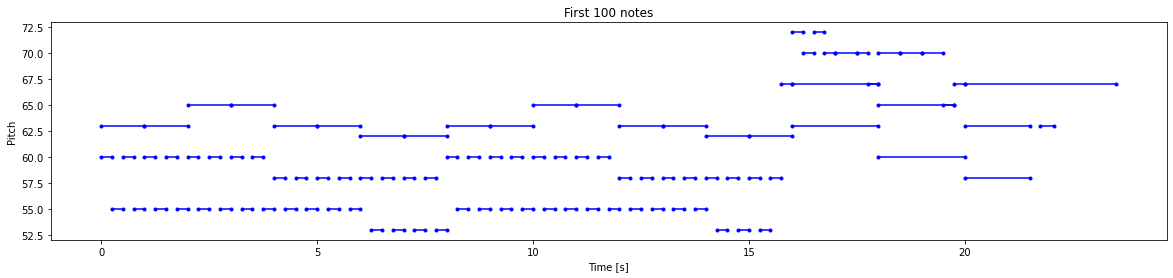

In [1012]:
plot_piano_roll(raw_notes, count=100)

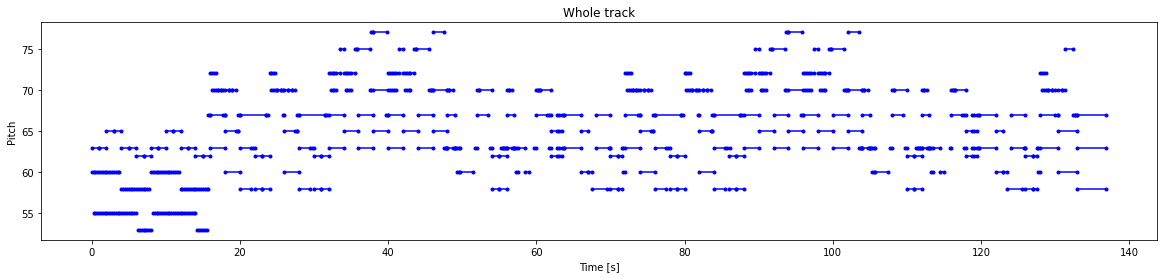

In [1013]:
plot_piano_roll(raw_notes)

In [1014]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

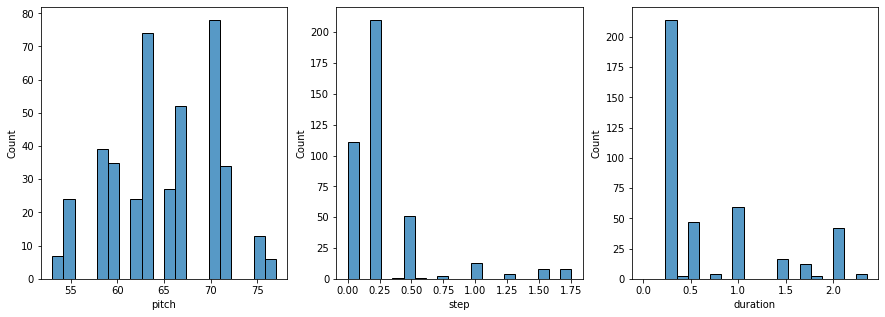

In [1015]:
plot_distributions(raw_notes)

In [1016]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [1018]:
num_files = 21
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [1019]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 14702


In [1020]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [1021]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [1022]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [1054]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [1055]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.46875   0.        0.25     ]
 [0.4921875 0.        1.       ]
 [0.4296875 0.25      0.25     ]
 [0.46875   0.25      0.25     ]
 [0.4296875 0.25      0.25     ]
 [0.46875   0.25      0.25     ]
 [0.4921875 0.        1.       ]
 [0.4296875 0.25      0.25     ]
 [0.46875   0.25      0.25     ]
 [0.4296875 0.25      0.25     ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=58.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.25>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.25>}


In [1056]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [1057]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [1058]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [1059]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_16 (LSTM)                 (None, 128)          67584       ['input_17[0][0]']               
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_16[0][0]']                
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_16[0][0]']                
                                                                                           

In [1060]:
losses = model.evaluate(train_ds, return_dict=True)
losses

229/229 [==============================] - 5s 12ms/step - loss: 5.3105 - duration_loss: 0.2513 - pitch_loss: 4.8461 - step_loss: 0.2130


{'loss': 5.310512065887451,
 'duration_loss': 0.2513445317745209,
 'pitch_loss': 4.846120357513428,
 'step_loss': 0.21304726600646973}

In [1061]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [1062]:
model.evaluate(train_ds, return_dict=True)

229/229 [==============================] - 4s 12ms/step - loss: 0.7067 - duration_loss: 0.2513 - pitch_loss: 4.8461 - step_loss: 0.2130


{'loss': 0.7066976428031921,
 'duration_loss': 0.2513445317745209,
 'pitch_loss': 4.846120357513428,
 'step_loss': 0.21304726600646973}

In [1063]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [1064]:
%%time
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100
229/229 [==============================] - 11s 40ms/step - loss: 0.3960 - duration_loss: 0.0848 - pitch_loss: 3.8768 - step_loss: 0.1174
Epoch 2/100
229/229 [==============================] - 7s 32ms/step - loss: 0.3630 - duration_loss: 0.0782 - pitch_loss: 3.5597 - step_loss: 0.1068
Epoch 3/100
229/229 [==============================] - 8s 33ms/step - loss: 0.3513 - duration_loss: 0.0746 - pitch_loss: 3.5151 - step_loss: 0.1009
Epoch 4/100
229/229 [==============================] - 7s 31ms/step - loss: 0.3423 - duration_loss: 0.0705 - pitch_loss: 3.4663 - step_loss: 0.0984
Epoch 5/100
229/229 [==============================] - 7s 31ms/step - loss: 0.3257 - duration_loss: 0.0675 - pitch_loss: 3.3316 - step_loss: 0.0916
Epoch 6/100
229/229 [==============================] - 7s 32ms/step - loss: 0.3111 - duration_loss: 0.0650 - pitch_loss: 3.2058 - step_loss: 0.0859
Epoch 7/100
229/229 [==============================] - 7s 31ms/step - loss: 0.2986 - duration_loss: 0.0630 - pi

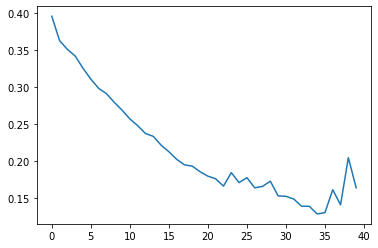

In [1065]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [1066]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [1076]:
temperature = 37.0
num_predictions = 300

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [1077]:
generated_notes.head(20)

,pitch,step,duration,start,end
0,61,0.317881,0.213279,0.317881,0.531160
1,112,0.000000,0.497020,0.317881,0.814901
2,12,0.000000,0.497916,0.317881,0.815797
3,76,0.404448,0.305050,0.722329,1.027380
4,64,0.000000,0.656184,0.722329,1.378513
5,58,0.216674,0.754809,0.939003,1.693812
6,43,0.241131,0.791420,1.180134,1.971553
7,46,0.273317,0.811550,1.453451,2.265001
8,32,0.289206,0.894579,1.742657,2.637236
9,97,0.297449,0.904312,2.040106,2.944418


In [1078]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
#display_audio(out_pm)
from IPython.display import FileLink
FileLink(out_file)
#from google.colab import files
#files.download(out_file)


C:\Users\hksca\OneDrive\Python\output.mid

In [600]:
def display_audio(pm: pretty_midi.PrettyMIDI,seconds=30):
    waveform=pm.fluidsynth(fs=_SAMPLING_RATE)
    #Take a sample of the generated waveform to mitigate kernel resets
    waveform_short=waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [62]:
display_audio(pm)

AttributeError: module 'fluidsynth' has no attribute 'Synth'